In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"
import numpyro

numpyro.enable_x64()
import jax
from jax._src.config import config

config.update("jax_enable_x64", True)
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import dynamicAll
from dynamicAll import models,fit
import numpy as np

# Sampling

In this tutorial we'll go over the basics of sampling using dynamicall.
We do this very simply using rejection sampling, leveraging Jax's vectorization capabilities.

## tdr; 

If you just want to see the code, here it is:


In [5]:
from astropy.stats import histogram

model_params = {"M": 1e5, "a": 0.5}
model = models.Plummer(**model_params)
samples = model.sample_w_conditional(N=10_000, save=False)

r = np.sqrt(samples[:, 0] ** 2 + samples[:, 1] ** 2 + samples[:, 2] ** 2)
v = np.sqrt(samples[:, 3] ** 2 + samples[:, 4] ** 2 + samples[:, 5] ** 2)


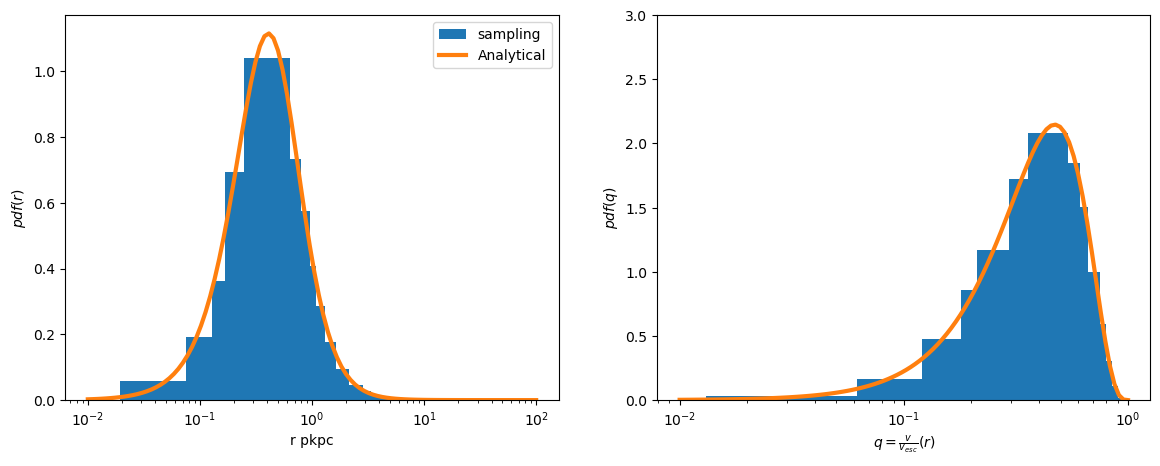

In [6]:
def g_q(q):
    """
    Probability distribution for q = v/v_esc.

    Parameters
    ----------
    q : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return q**2 * (1 - q**2) ** (7 / 2) * (512 / (7 * np.pi))


r_test = np.logspace(-2, 2, 100)


fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
r_test = np.logspace(-2, 2, 100)
N, bin_edges = histogram(r, bins="blocks")
r_center = (bin_edges[1:] + bin_edges[:-1]) / 2
q = v / model.v_esc(r)
# sanity checks
N, vel_edges = histogram(q, bins="blocks")
q_test = np.logspace(-2, 0, 100)


ax[0].hist(r, bins=bin_edges, density="True", label="sampling")
ax[0].plot(
    r_test,
    model.probability(r_test),
    label="Analytical",
    lw=3,
)
ax[0].set(xscale="log", xlabel="r pkpc", ylabel=r"$pdf(r)$")


ax[1].hist(q, bins=vel_edges, density=True)
ax[1].plot(
    q_test,
    g_q(q_test),
    lw=3,
)
ax[1].set(
    xscale="log", ylim=(0, 3), xlabel=r"$q =\frac{v}{v_{esc}}(r)$", ylabel=r"$pdf(q)$"
)
ax[0].legend()

## Rejection sampling

The basic outline of how we sample in cases where there isn't a convenient trick to sample the distribution, i.e. cases where we have some stellar distribution embedded in a dark halo, we can calculate the distribution function using the Eddington formula.
Then use rejection sampling in order to get samples.

model.D

In [7]:
E = jax.vmap(model.total_energy)(samples[:, :2], samples[:, 3:])

In [8]:
E[23], model.total_energy(samples[23, :2], samples[23, 3:])

(Array(-0.45358926, dtype=float64), Array(-0.45358926, dtype=float64))

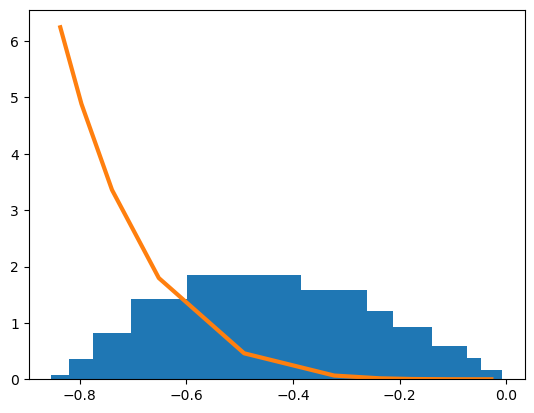

In [9]:
fig, ax = plt.subplots()
N, bin_edges = histogram(E, bins="blocks")
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
ax.hist(E, bins=bin_edges, density=True)
ax.plot(
    bin_centers, (-bin_centers) ** (7 / 2) * (1 - bin_centers / 0.5) ** (5 / 2), lw=3
)


Following Binney and Tremaine, we can write down the Eddington formula for the distribution function of an isotropic system as
$$
f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\frac{d}{d\epsilon}\int_{0}^{\infty} \frac{d\psi}{\sqrt{\epsilon-\psi}}\frac{d\rho}{d\psi}.
$$
This is following the Normal conventions where
$\psi = -\Phi + \Phi_{0}$ and $\epsilon = \psi - \frac{1}{2}v^{2}$.
In cases where a system extends towards infinity, $\Phi_{0} = 0$ and the relative energy $\epsilon = $ binding energy.



An equivalent formula is given by:
$$
f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\int_{0}^{\infty} \frac{d\psi}{\sqrt{\epsilon-\psi}}\frac{d^{2}\rho}{d\psi^{2}} + \frac{1}{\sqrt{\epsilon}}\left(\frac{d\rho}{d\psi}\right)_{\psi=0}.
$$

For numerical calculations e.g. sampling, it might be easier to not have to calculate $\rho(\psi)$ as it may not be possible to write down in closed form.
Fortunately, $\rho(\psi)$ only appears as a derivative in the above formula we can rewrite it as 
This mean we can use the fact that

$$d\psi = \frac{d\psi}{dr}dr$$
$$\frac{d}{d\psi}= \frac{dr}{d\psi}\frac{d}{dr} $$
$$\frac{d\psi(r)}{dr} = -\frac{GM(r)}{r^{2}}$$



$$
f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\int_{r_\epsilon}^{\infty} \frac{k(r)dr}{\sqrt{\epsilon - \psi(r)}}
$$
where k(r)
$$
k(r) = \frac{r^{2}}{GM(r)}\left[\rho''(r)\ + \rho'(r)\left(\frac{2}{r} - \frac{4\pi\rho(r)}{M(r)}\right)\right]

In [98]:
from dynamicAll import models

# Define parameters
dm = {"rhos": 6.4e7, "rs": 1.0, "a": 1.0, "b": 1.0, "c": 3.0}
stellar = {"M": 1.0e7, "a": 0.25}

stellar_component = models.Plummer(**stellar)
stellar_test = {
    "rhos": 1e3 * 3 / 4 / jnp.pi / 0.25**3,
    "rs": 1.0,
    "a": 0.1,
    "b": 2.0,
    "c": 5.0,
}
# stellar_component = models.HernquistZhao(**stellar_test)
# dm_component = models.HernquistZhao(**dm)
dm_component = models.HernquistZhao(**stellar_test)
# dm_component = models.Plummer(**stellar)

In [99]:
r200 = dm_component.r200()
r200

Array(0.00533676, dtype=float64)

In [100]:
(jnp.sqrt(-dm_component.potential(r200))), jnp.sqrt(-dm_component.potential(1e-8))

(Array(0.54211353, dtype=float64), Array(0.54212017, dtype=float64))

In [101]:
jnp.log(r200)

Array(-5.23313695, dtype=float64)

In [102]:
import jax
import jax.numpy as jnp

# r = jnp.logspace(-8, jnp.log10(r200), 10_000)
r = jnp.logspace(-8, 5, 10_000)
rho = stellar_component.density(r)
phi = -jax.vmap(dm_component.potential)(r)

In [103]:
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import astropy.units as u

rho_of_phi = InterpolatedUnivariateSpline(phi, rho, k=3)
der = rho_of_phi.derivative(phi)

In [107]:
def analytic_drho_dr(r, M, a):
    # derivative of plummer density with respect to r
    return -3 * M * (5 / 2) * 2 * r * (1 + r**2 / a**2) ** (-7 / 2) / a**5 / 4 / np.pi

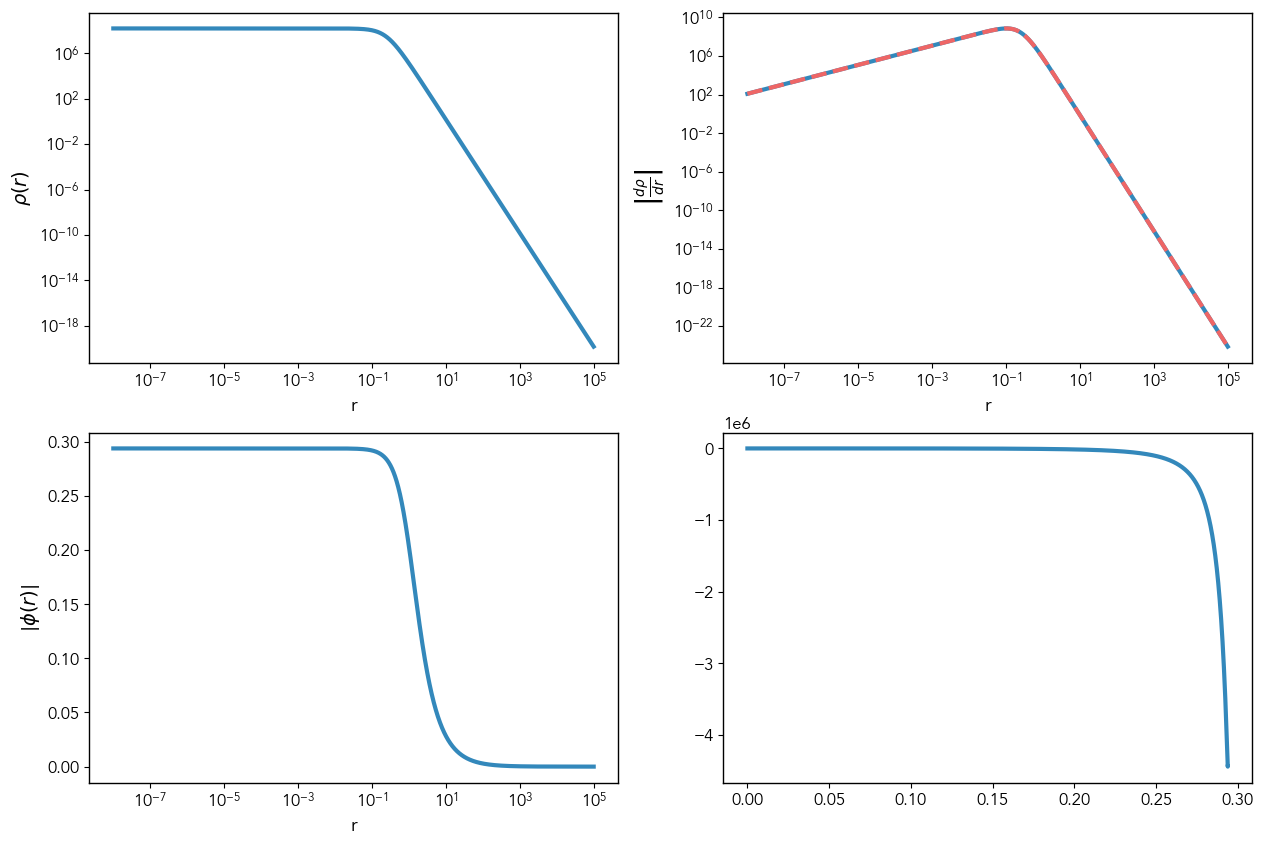

In [113]:
rho = stellar_component.density(r)
drho = jax.grad(stellar_component.density)
lw = 3
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
ax = ax.flatten()
ax[0].plot(r, rho, lw=lw)
ax[0].set(xscale="log", yscale="log", xlabel="r", ylabel=r"$\rho(r)$")
ax[1].plot(r, jnp.abs(jax.vmap(drho)(r)), label="analytical", lw=lw)
ax[1].plot(
    r,
    jnp.abs(analytic_drho_dr(r, stellar["M"], stellar["a"])),
    label="analytical",
    lw=lw,
    linestyle="--",
)
ax[1].set(
    xscale="log", yscale="log", xlabel="r", ylabel=r"$\left|\frac{d\rho}{dr}\right|$"
)

ax[2].plot(r, phi, lw=lw)
ax[2].set(xscale="log", xlabel="r", ylabel=r"$\left|\phi(r)\right|$")

ax[3].plot(
    phi,
    analytic_drho_dr(r, stellar["M"], stellar["a"])
    * r**2
    / stellar_component.G
    / stellar_component.mass(r),
    lw=lw,
)
ax[3].set(
    xscale="log", yscale="log", xlabel="r", ylabel=r"$\left|\frac{d\rho}{dr}\right|$"
)

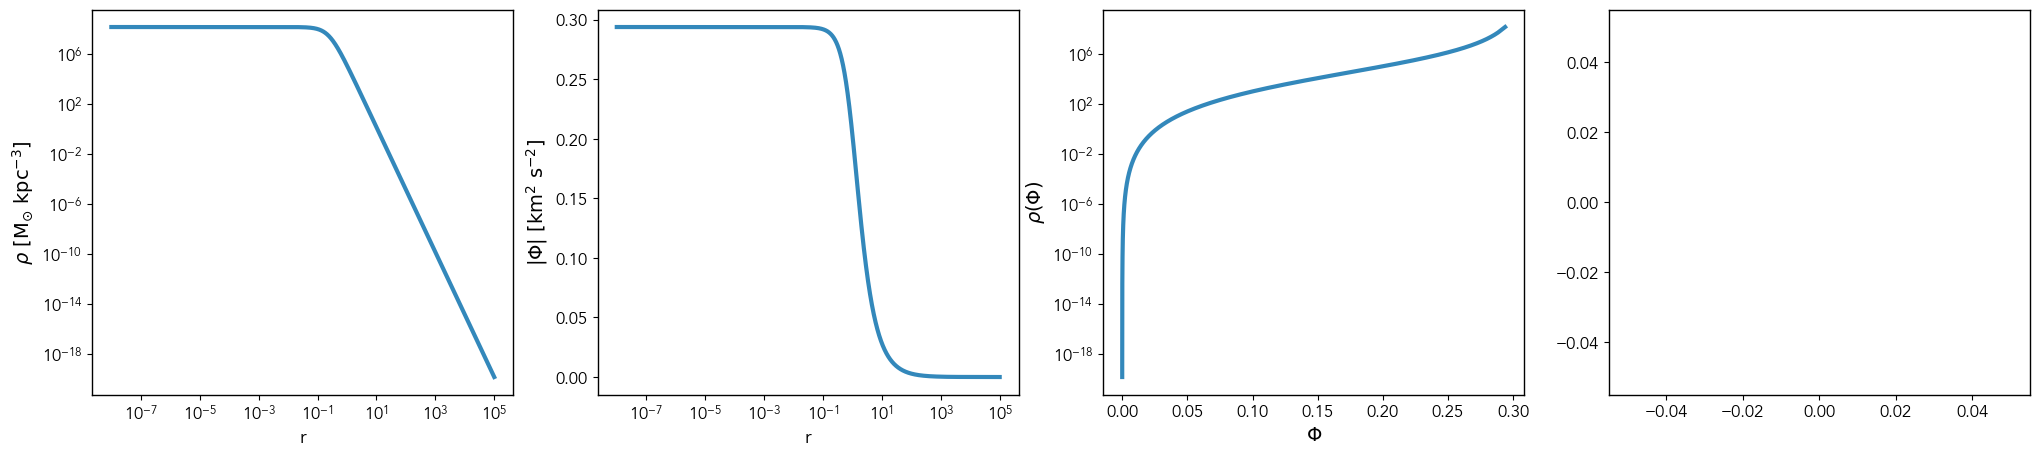

In [114]:
import matplotlib.pyplot as plt

plt.style.use("/Users/juan/phd/matplotlib/jdefault.mplstyle")
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
ax[0].plot(r, rho)
ax[0].set(
    xscale="log", yscale="log", xlabel="r", ylabel=r"$\rho~[\rm M_{\odot}~kpc^{-3}]$"
)
# ax[1].plot(r,(phi*u.kpc**2/u.s**2).to(u.km**2/u.s**2))
ax[1].plot(r, phi)
# ax[1].plot(r,dm_test.potential(r),linestyle='--')
ax[1].set(
    xscale="log",
    # yscale = 'log',
    xlabel="r",
    ylabel=r"$|\Phi|~[\rm km^{2}~s^{-2}]$",
)
# ax[2].plot((phi*u.kpc**2/u.s**2).to(u.km**2/u.s**2),rho)
ax[2].plot(phi, rho)
# ax[2].plot((phi*u.kpc**2/u.s**2).to(u.km**2/u.s**2),rho_of_phi(phi),linestyle='--')
ax[2].set(
    # xscale = 'log',
    yscale="log",
    xlabel="$\Phi$",
    ylabel=r"$\rho(\Phi)$",
)

# ax[3].plot((phi*u.kpc**2/u.s**2).to(u.km**2/u.s**2),jax.vmap(jax.grad(rho_of_phi))((phi*u.kpc**2/u.s**2).to(u.km**2/u.s**2)),linestyle='--')
# plot numerical derivative not using jax
# ax[3].plot(phi[:10], np.gradient(rho, phi[:10]))
# ax[3].plot(phi[:10], jax.vmap(jax.grad(rho_of_phi))(phi[:10]))
ax[3].plot(phi, der)
# ax[3].plot(phi, jax.vmap(jax.grad(rho_of_phi))(phi))
ax[3].set(
    # xscale="log",
    # yscale="log",
    # xlabel="$\Phi$",
    # ylabel=r"$\frac{d\rho}{d\Phi}$",
);

In [49]:
jax.vmap(jax.grad(rho_of_phi))(phi)

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float64)

In [23]:
import numpy as np

x, w = np.polynomial.legendre.leggauss(512)  # TODO: Find a better way to set this.

x = jnp.array(x)
w = jnp.array(w)
drho_dphi = jax.vmap(jax.grad(rho_of_phi))


def DistributionFunction(E):
    def integral(E):
        x0 = 0.0
        x1 = E
        xi = 0.5 * (x1 - x0) * x + 0.5 * (x1 + x0)
        wi = 0.5 * (x1 - x0) * w
        return jnp.sum(wi * drho_dphi(xi) / jnp.sqrt(E - xi))

    out = jax.grad(integral)(E)
    coeff = jnp.pi ** (-2) / jnp.sqrt(8)
    return jnp.nan_to_num(coeff * out)

In [231]:
import astropy.constants as const

print(const.G.to(u.kpc * u.km**2 / u.s**2 / u.Msun))
E = jnp.linspace(0, 3500, 1000)

print(E)

4.300917270036279e-06 km2 kpc / (solMass s2)
[   0.            3.5035035     7.00700701   10.51051051   14.01401401
   17.51751752   21.02102102   24.52452452   28.02802803   31.53153153
   35.03503504   38.53853854   42.04204204   45.54554555   49.04904905
   52.55255255   56.05605606   59.55955956   63.06306306   66.56656657
   70.07007007   73.57357357   77.07707708   80.58058058   84.08408408
   87.58758759   91.09109109   94.59459459   98.0980981   101.6016016
  105.10510511  108.60860861  112.11211211  115.61561562  119.11911912
  122.62262262  126.12612613  129.62962963  133.13313313  136.63663664
  140.14014014  143.64364364  147.14714715  150.65065065  154.15415415
  157.65765766  161.16116116  164.66466466  168.16816817  171.67167167
  175.17517518  178.67867868  182.18218218  185.68568569  189.18918919
  192.69269269  196.1961962   199.6996997   203.2032032   206.70670671
  210.21021021  213.71371371  217.21721722  220.72072072  224.22422422
  227.72772773  231.23123123  234

In [232]:
DF = jax.vmap(DistributionFunction)(E)

[None, Text(0.5, 0, '$\\epsilon$'), Text(0, 0.5, '$f(\\epsilon)$')]

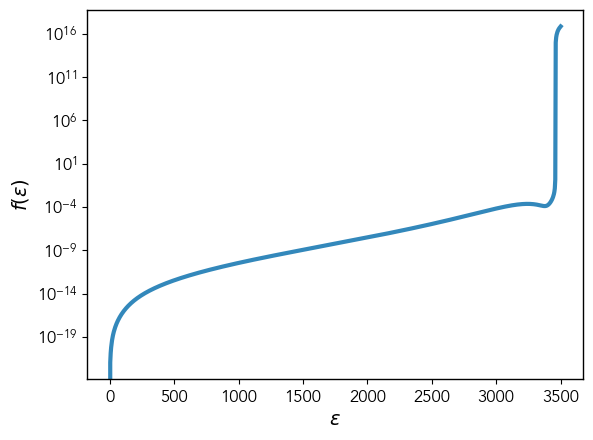

In [234]:
fig, ax = plt.subplots()
ax.plot(E, DF)
ax.set(yscale="log", xlabel=r"$\epsilon$", ylabel=r"$f(\epsilon)$")
ax.axvline(4 * j, color="k", linestyle="--")

In [1]:
xi, wi = dm_component._xj, dm_component._wj
r_lim = 50
x0 = jnp.arcsin(8.88188420e-06 / r_lim)
# x0 = 0
x1 = jnp.pi / 2

xk = 0.5 * (x1 - x0) * xi + 0.5 * (x1 + x0)
wk = 0.5 * (x1 - x0) * wi

NameError: name 'dm_component' is not defined